# CNN Cancer Detection

The goal of this project is to identify metastatic cancer in small image patches taken from larger digital pathology scans by leverging deep learning model

This is a kaggle competition (link:https://www.kaggle.com/c/histopathologic-cancer-detection/overview)

## 1. Data Preprocessing

### 1.1 Load Data

In [1]:
import pandas as pd
import numpy as np
import glob
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
from sklearn.metrics import roc_auc_score
import seaborn as sns
from PIL import Image
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline

train = pd.read_csv('./histopathologic-cancer-detection/train_labels.csv')

### 1.2 Add Image Path

In [2]:
img_path_train = glob.glob('./histopathologic-cancer-detection/train/*.tif')
img_id_train = [i.split('/')[3].split('.')[0] for i in img_path_train]
img_pair = dict(zip(img_id_train,img_path_train))
train['img_path'] = train['id'].map(img_pair)

img_path_test = glob.glob('./histopathologic-cancer-detection/test/*.tif')
img_id_test = [i.split('/')[3].split('.')[0] for i in img_path_test]
test = pd.DataFrame({'img_path':img_path_test,'id':img_id_test})

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220025 entries, 0 to 220024
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   id        220025 non-null  object
 1   label     220025 non-null  int64 
 2   img_path  220025 non-null  object
dtypes: int64(1), object(2)
memory usage: 5.0+ MB


### 1.3 Check Missing Value

In [4]:
train.isnull().sum()

id          0
label       0
img_path    0
dtype: int64

### 1.4 Check Duplicates

In [5]:
train.duplicated().sum()

0

## 2. Data Visualization

### 2.1 Histogram

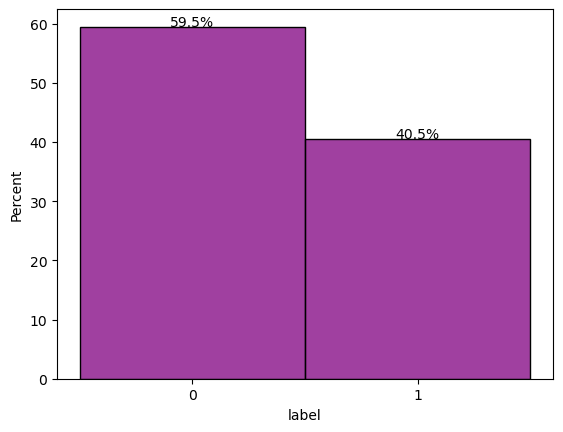

In [6]:
ax = sns.histplot(train['label'].astype(str),stat='percent',color="purple",binwidth=1)
for p in ax.patches:
    ax.annotate(f'{p.get_height():.1f}%', xy=(p.get_x() + p.get_width() / 2, p.get_height()+0.1),
            xytext=(0, 3), textcoords='offset points',
            ha='center', va='center')

### 2.2 Image Visualization

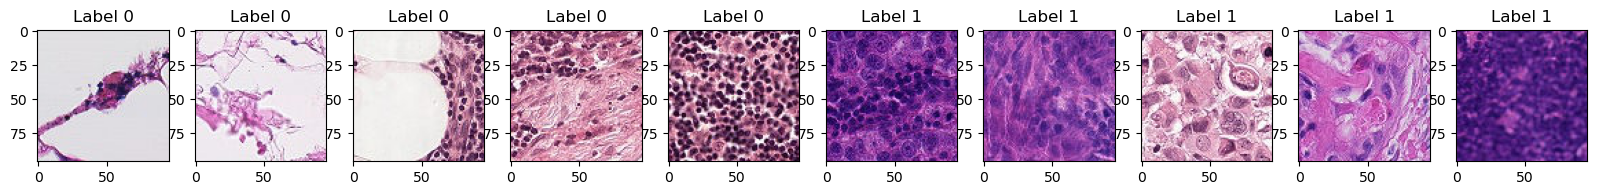

In [7]:
# Random pick 5 images from each label and visualize
sample_view = train.groupby('label').apply(lambda x: x.sample(n=5))[['label','img_path']].values.tolist()

fig, ax = plt.subplots(1, len(sample_view), figsize = (20, 2))
for i, j in enumerate(sample_view):
    image = mpimg.imread(j[1])
    ax[i].imshow(image)
    ax[i].set_title('Label '+str(j[0]))

plt.show()

Based on the plot, it is hard for us to tell the difference between two lables

## 3. DModel Architecture

### 3.1 Image Transformation

In [8]:
all_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

In [9]:
class data_transform():
    def __init__(self, data,transform):
        self.data = data
        self.transform = transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        img_path = self.data.iloc[idx]['img_path']
        img = Image.open(img_path)
        img_t = self.transform(img)
        try:
            label = torch.tensor(self.data.iloc[idx]['label'])
            return img_t, label
        except KeyError as ke:
            pass
        return img_t

In [10]:
# Use sample data of 20000 each per label to speed up training process
sample_train = train.groupby('label').apply(lambda x: x.sample(n=20000)).reset_index(drop=True)
# Transform data
train_d = data_transform(sample_train,all_transforms)
# Split train data into 75% train and 25% validation
train_size = int(0.75 * len(train_d))
val_size = len(train_d) - train_size
train_data, val_data = torch.utils.data.random_split(train_d, [train_size, val_size])
# Create dataloader to load data in batch
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False)

### 3.2 Build CNN

In [11]:
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(32*24*24, 64)
        self.fc2 = nn.Linear(64, 2)
        
    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = x.view(-1, 32*24*24)
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x

### 3.3 Define Loss function and optimizer

In [12]:
model = MyModel()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

## 4. Modeling And Evaluation

### 4.1 Training Model

In [13]:
num_epochs = 3
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        outputs = model(images)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if (i + 1) % 125 == 0:
            print('Epoch [{}/{}], Loss: {:.4f}'
                  .format(epoch + 1, num_epochs, loss.item()))

Epoch [1/3], Loss: 0.5097
Epoch [1/3], Loss: 0.3871
Epoch [1/3], Loss: 0.5735
Epoch [2/3], Loss: 0.4404
Epoch [2/3], Loss: 0.4052
Epoch [2/3], Loss: 0.4839
Epoch [3/3], Loss: 0.4688
Epoch [3/3], Loss: 0.4965
Epoch [3/3], Loss: 0.6438


### 4.2 Model Evaluation

In [14]:
y_true = []
y_scores = []
with torch.no_grad():
    for i, (images, labels) in enumerate(val_loader):
        outputs = model(images)
        y_true.extend(labels.numpy())
        y_scores.extend(torch.softmax(outputs, dim=1)[:, 1].numpy())

auc_score = roc_auc_score(y_true, y_scores)
print('Overall AUC score:', auc_score)

Overall AUC score: 0.8756298847572929


### 4.3 Hyperparameter Tuning

In [15]:
# Try different number of epoch and CNN with different parameters
# Higher out_channels and kernel_size can capture more complex data and feature, 
# but may also increase computation time
class NewModel(nn.Module):
    def __init__(self):
        super(NewModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(64*24*24, 128)
        self.fc2 = nn.Linear(128, 2)
        
    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = x.view(-1, 64*24*24)
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [16]:
new_model = NewModel()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(new_model.parameters(), lr=0.001)

### 4.4 Train And Evaluate Model With New Parameters

In [17]:
num_epochs = 5
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        outputs = new_model(images)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if (i + 1) % 125 == 0:
            print('Epoch [{}/{}], Loss: {:.4f}'
                  .format(epoch + 1, num_epochs, loss.item()))

Epoch [1/5], Loss: 0.5433
Epoch [1/5], Loss: 0.4909
Epoch [1/5], Loss: 0.4362
Epoch [2/5], Loss: 0.4534
Epoch [2/5], Loss: 0.3547
Epoch [2/5], Loss: 0.3608
Epoch [3/5], Loss: 0.3191
Epoch [3/5], Loss: 0.4724
Epoch [3/5], Loss: 0.3783
Epoch [4/5], Loss: 0.4385
Epoch [4/5], Loss: 0.3817
Epoch [4/5], Loss: 0.4032
Epoch [5/5], Loss: 0.3408
Epoch [5/5], Loss: 0.3444
Epoch [5/5], Loss: 0.4525


In [18]:
y_true = []
y_scores = []
with torch.no_grad():
    for i, (images, labels) in enumerate(val_loader):
        outputs = new_model(images)
        y_true.extend(labels.numpy())
        y_scores.extend(torch.softmax(outputs, dim=1)[:, 1].numpy())

auc_score = roc_auc_score(y_true, y_scores)
print('Overall AUC score:', auc_score)

Overall AUC score: 0.9180160682421427


### 4.5 Pick Best Model And Predict On Test

In [20]:
test_d = data_transform(test,all_transforms)
test_loader = DataLoader(test_d, batch_size=32, shuffle=False)

In [22]:
# Model after hyperparameter tuning gives us better result, hence use that model
y_pred = []
with torch.no_grad():
    for i, images in enumerate(test_loader):
        outputs = new_model(images)
        y_pred.extend(torch.softmax(outputs, dim=1)[:, 1].numpy())

In [23]:
final_test = test
final_test['label'] = y_pred
final_test = final_test.drop(columns='img_path')
final_test.to_csv('test1_model.csv',index=False)

## 5. Conclusions

In this project, we only train 40000 images in total (20000 images per label). If we train on the full dataset, there is a pretty high chance of improving final score. In addition, we can also do more hyperparameter tuning or use different models to potentially improve the score in the future